# Iterative reconstruction

In [22]:
import numpy as np
import cupy as cp
import dxchange
import matplotlib.pyplot as plt
from holotomocupy.holo import G, GT
from holotomocupy.magnification import M, MT
from holotomocupy.shift import S, ST, registration_shift
from holotomocupy.chunking import gpu_batch
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.proc import dai_yuan, linear
import holotomocupy.chunking as chunking


%matplotlib inline

chunking.global_chunk = 1

In [ ]:
# Init data sizes and parametes of the PXM of ID16A

In [23]:
n = 1024  # object size in each dimension
ntheta = 1  # number of angles (rotations)

center = n/2  # rotation axis

# ID16a setup
ndist = 4

detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16
# sample size after demagnification
ne = int(np.ceil((n+2*pad)/norm_magnifications[-1]/8))*8  # make multiple of 8

In [ ]:
## Read data

In [24]:
data00 = np.zeros([ntheta, ndist, n, n], dtype='float32')
ref00 = np.zeros([1, ndist, n, n], dtype='float32')

for k in range(ndist):
    data00[:, k] = dxchange.read_tiff(f'data/data_{n}_{k}.tiff')[:ntheta]
    ref00[:, k] = dxchange.read_tiff(f'data/ref_{n}_{k}.tiff')
shifts_drift_init = np.load('data/shifts_drift.npy')[:ntheta, :ndist]
shifts_ref_init = np.load('data/shifts_ref.npy')[:ntheta, :ndist]
shifts_ref0_init = np.load('data/shifts_ref0.npy')[:, :ndist]
shifts_init = shifts_drift_init

In [ ]:
# Find shifts of reference images

In [25]:
shifts_ref0 = np.zeros([1, ndist, 2], dtype='float32')
for k in range(ndist):
    shifts_ref0[:, k] = registration_shift(ref00[:, k], ref00[:, 0], upsample_factor=1000)

print(f'Found shifts: \n{shifts_ref0=}')
print(f'Correct shifts: \n{shifts_ref0_init=}')

shifts_ref = np.zeros([ntheta, ndist, 2], dtype='float32')
for k in range(ndist):
    im = np.tile(ref00[0, 0], [ntheta, 1, 1])
    shifts_ref[:, k] = registration_shift(data00[:, k], im, upsample_factor=1000)
    
print(f'Found shifts: \n{shifts_ref=}')
print(f'Correct shifts: \n{shifts_ref_init=}')


Found shifts: 
shifts_ref0=array([[[ 0.   ,  0.   ],
        [-1.202,  1.42 ],
        [-0.572,  1.013],
        [-0.803,  1.528]]], dtype=float32)
Correct shifts: 
shifts_ref0_init=array([[[ 0.        ,  0.        ],
        [-1.2042098 ,  1.4274013 ],
        [-0.5933894 ,  1.0185907 ],
        [-0.81615317,  1.5357459 ]]], dtype=float32)
Found shifts: 
shifts_ref=array([[[ 1.623, -0.705],
        [-1.638, -0.78 ],
        [-1.545,  1.318],
        [-1.804,  0.486]]], dtype=float32)
Correct shifts: 
shifts_ref_init=array([[[ 1.6345956 , -0.7230556 ],
        [-1.6381626 , -0.7971997 ],
        [-1.5440626 ,  1.3147254 ],
        [-1.8124148 ,  0.50514865]]], dtype=float32)


In [ ]:
### Assuming the shifts are calculated, shifts refs back

In [26]:
data0 = data00.copy()
ref0 = ref00.copy()
# shifted refs for correction
for k in range(ndist):
    # shift refs back
    ref0[:, k] = ST(ref0[:, k].astype('complex64'), shifts_ref0[:, k]).real

ref0c = np.tile(np.array(ref0), (ntheta, 1, 1, 1))
for k in range(ndist):
    # shift refs the position where they were when collecting data
    ref0c[:, k] = S(ref0c[:, k].astype('complex64'), shifts_ref[:, k]).real

In [27]:
rdata = data0/ref0c

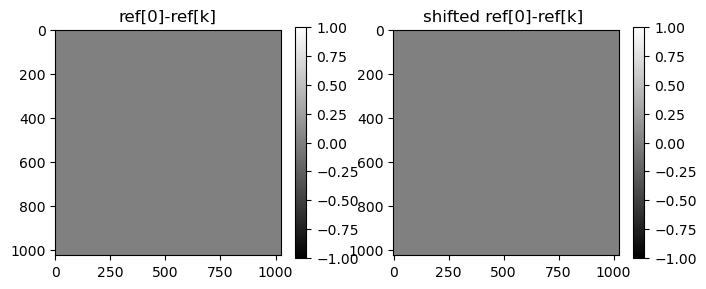

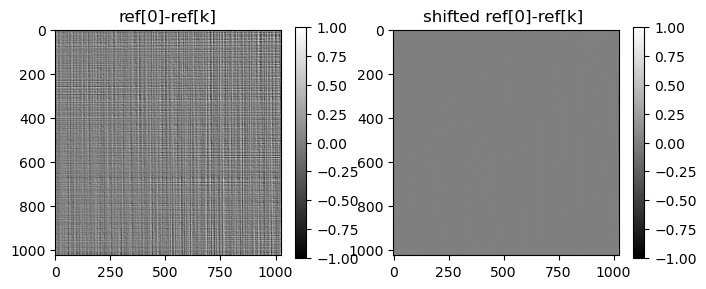

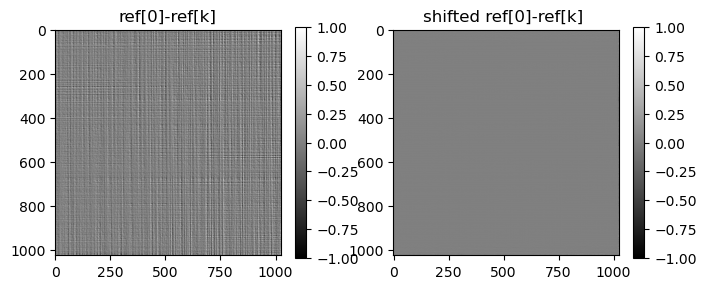

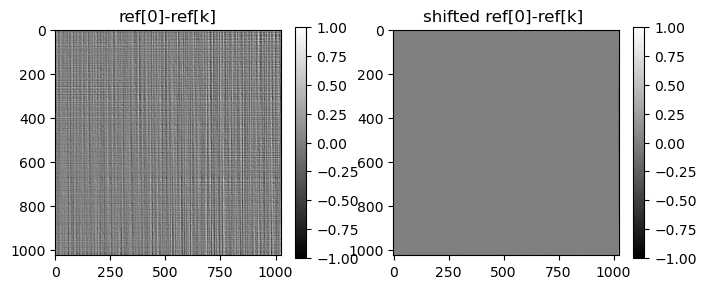

In [28]:
for k in range(4):
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    im = axs[0].imshow(ref00[0, 0]-ref00[0, k], cmap='gray',vmax=1,vmin=-1)
    axs[0].set_title('ref[0]-ref[k]')
    fig.colorbar(im)
    # ,vmin=-500,vmax=500)
    im = axs[1].imshow(ref0[0, 0]-ref0[0, k], cmap='gray',vmax=1,vmin=-1)
    axs[1].set_title('shifted ref[0]-ref[k] ')
    fig.colorbar(im)

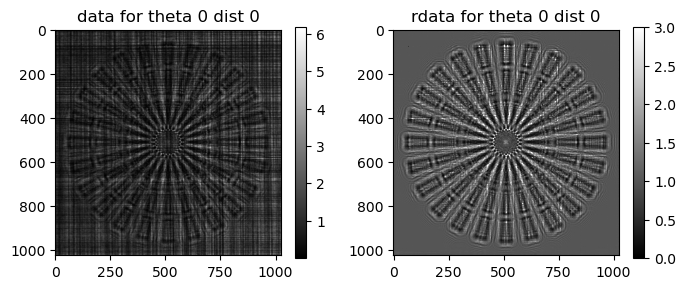

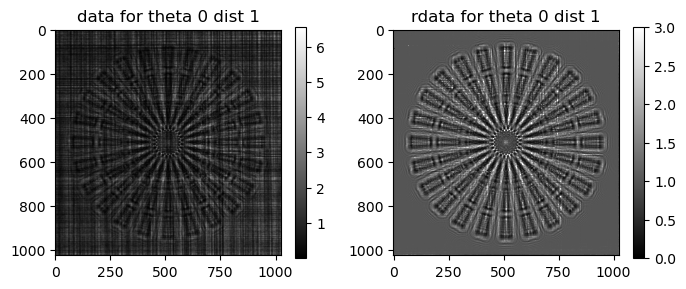

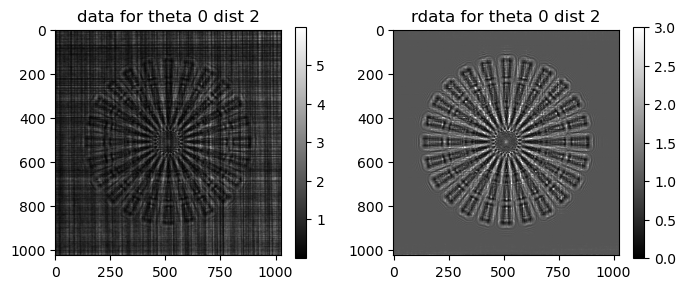

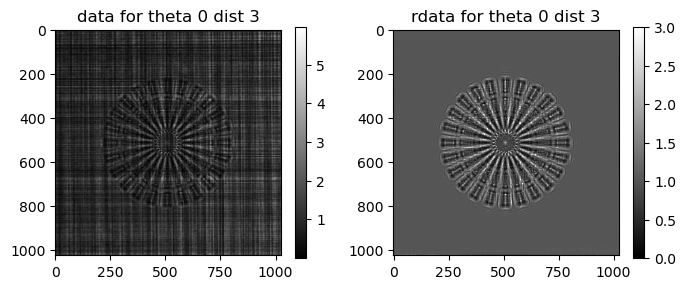

In [29]:
for k in range(ndist):
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    im=axs[0].imshow(data0[-1,k],cmap='gray')#,vmin = 0.5,vmax=2 )
    axs[0].set_title(f'data for theta {ntheta-1} dist {k}')
    fig.colorbar(im)
    im=axs[1].imshow(rdata[-1,k],cmap='gray',vmin = 0,vmax=3)
    axs[1].set_title(f'rdata for theta {ntheta-1} dist {k}')
    fig.colorbar(im)

In [ ]:
### Scale images

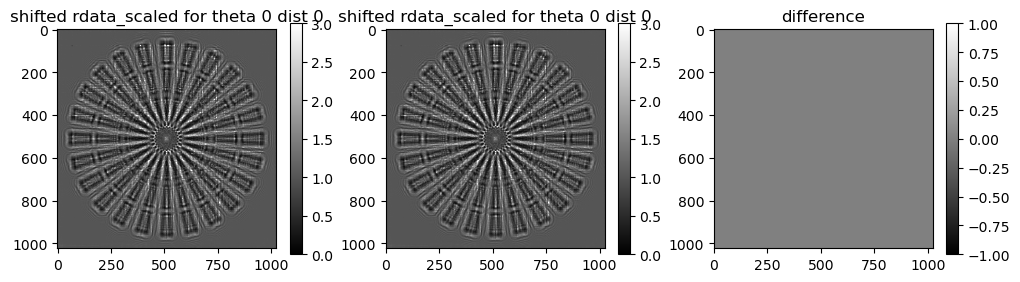

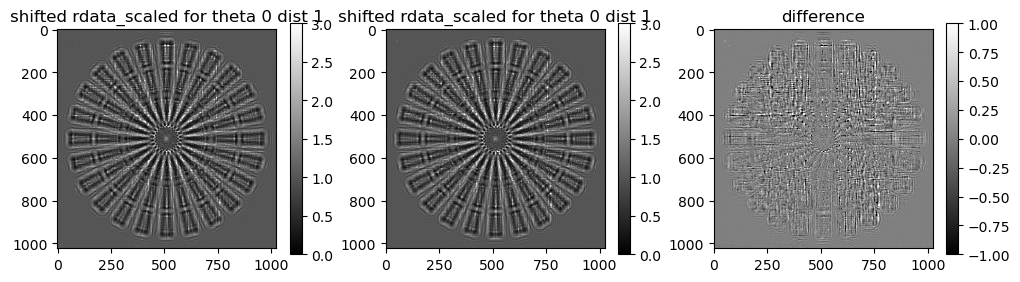

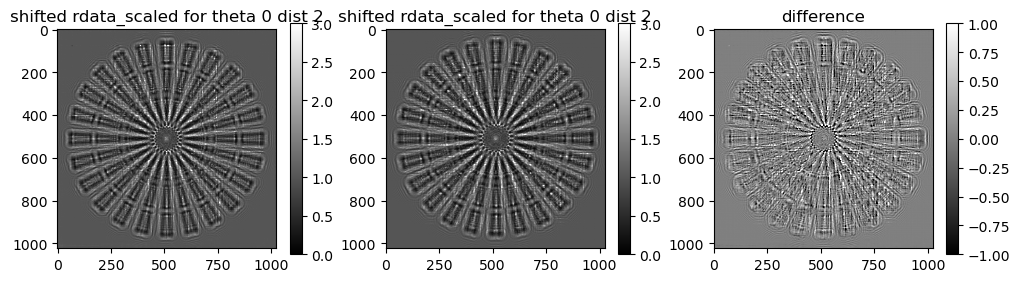

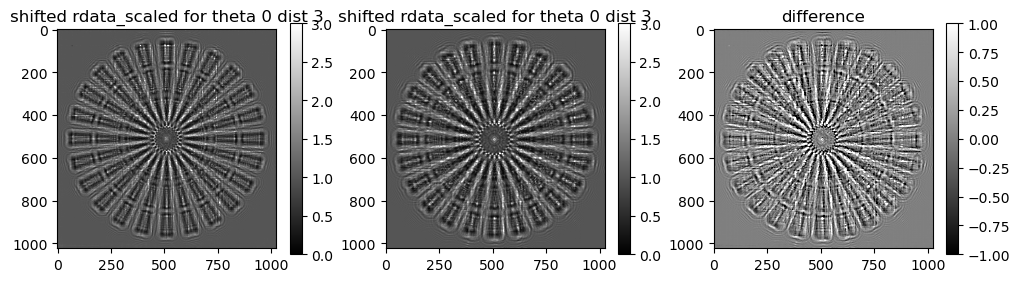

In [30]:
rdata_scaled = rdata.copy()

for k in range(ndist):
    rdata_scaled[:, k] = M(rdata_scaled[:, k], 1/norm_magnifications[k], n).real

for k in range(ndist):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    im = axs[0].imshow(rdata_scaled[0, 0], cmap='gray', vmin=0, vmax=3)
    axs[0].set_title(f'shifted rdata_scaled for theta 0 dist {k}')
    fig.colorbar(im)
    im = axs[1].imshow(rdata_scaled[0, k], cmap='gray', vmin=0, vmax=3)
    axs[1].set_title(f'shifted rdata_scaled for theta {ntheta-1} dist {k}')
    fig.colorbar(im)
    im = axs[2].imshow(rdata_scaled[0, k]-rdata_scaled[0, 0], cmap='gray', vmin=-1, vmax=1)
    axs[2].set_title(f'difference')
    fig.colorbar(im)

In [ ]:
### Align images between different planes


In [ ]:
#### Approach 1. Align data

In [31]:
# shifts_drift = np.zeros([ntheta,ndist,2],dtype='float32')

# for k in range(1,ndist):
#     shifts_drift[:,k] = registration_shift(rdata_scaled[:,k],rdata_scaled[:,0],upsample_factor=1000)

# # note shifts_drift should be after magnification.
# shifts_drift*=norm_magnifications[np.newaxis,:,np.newaxis]

# shifts_drift_median = shifts_drift.copy()
# shifts_drift_median[:] = np.median(shifts_drift,axis=0)

# print(shifts_drift_median[0],shifts_drift_init[0])
# for k in range(ndist):
#     fig, axs = plt.subplots(1, 2, figsize=(10, 3))
#     im=axs[0].plot(shifts_drift[:,k,0],'.')
#     im=axs[0].plot(shifts_drift_median[:,k,0],'.')
#     im=axs[0].plot(shifts_drift_init[:,k,0],'r.')
#     axs[0].set_title(f'distance {k}, shifts y')
#     im=axs[1].plot(shifts_drift[:,k,1],'.')
#     im=axs[1].plot(shifts_drift_median[:,k,1],'.')
#     im=axs[1].plot(shifts_drift_init[:,k,1],'r.')
#     axs[1].set_title(f'distance {k}, shifts x')
#     # plt.show()

In [ ]:
#### Approach 2. Align CTF reconstructions from 1 distance

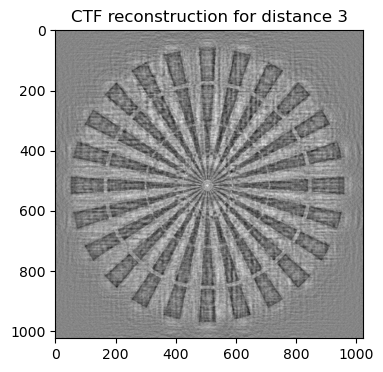

Found shifts: 
shifts_drift=array([[[ 0.        ,  0.        ],
        [ 0.5743313 ,  0.28860387],
        [-1.2976288 ,  1.4960606 ],
        [ 2.3344269 , -3.4822235 ]]], dtype=float32)
Correct shifts: 
shifts_drift_init=array([[[ 0. ,  0. ],
        [ 0.6,  0.3],
        [-1.3,  1.5],
        [ 2.3, -3.5]]], dtype=float32)


In [32]:
recCTF_1dist = np.zeros([ntheta, ndist, n, n], dtype='float32')
distances_ctf = (distances/norm_magnifications**2)[:ndist]

for k in range(ndist):
    recCTF_1dist[:, k] = CTFPurePhase(
        rdata_scaled[:, k:k+1], distances_ctf[k:k+1], wavelength, voxelsize, 1e-1)

plt.figure(figsize=(4, 4))
plt.title(f'CTF reconstruction for distance {ndist-1}')
plt.imshow(recCTF_1dist[0, -1], cmap='gray')
plt.show()

shifts_drift = np.zeros([ntheta, ndist, 2], dtype='float32')

for k in range(1, ndist):
    shifts_drift[:, k] = registration_shift(
        recCTF_1dist[:, k], recCTF_1dist[:, 0], upsample_factor=1000)

# note shifts_drift should be after magnification.
shifts_drift *= norm_magnifications[np.newaxis, :, np.newaxis]

    
print(f'Found shifts: \n{shifts_drift=}')
print(f'Correct shifts: \n{shifts_drift_init=}')


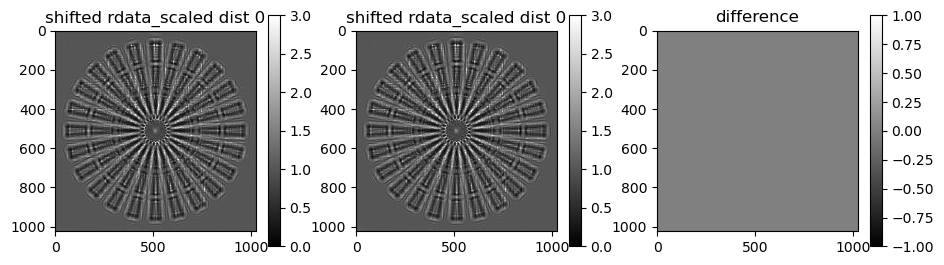

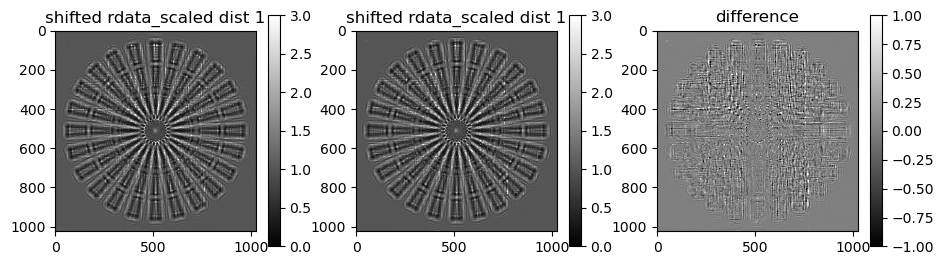

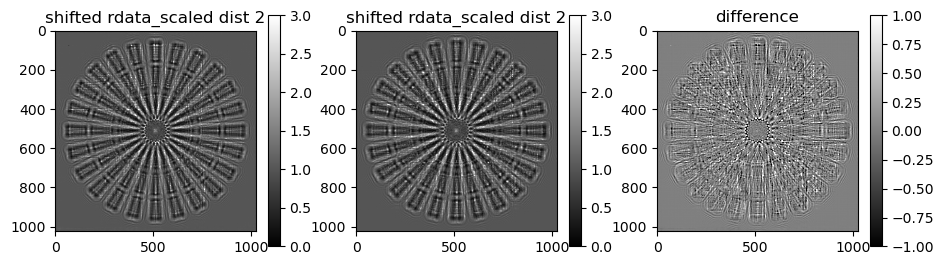

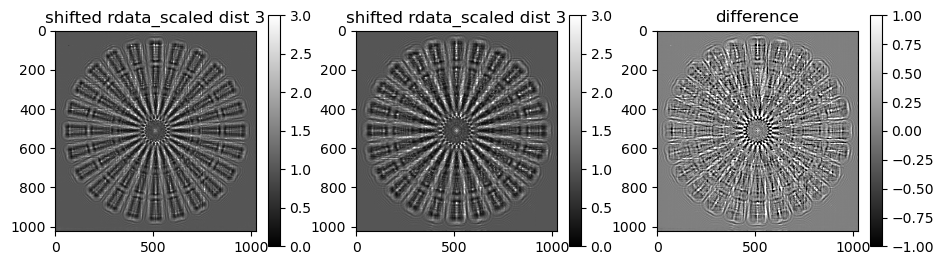

In [33]:
rdata_scaled_aligned = rdata_scaled.copy()
for k in range(ndist):
    rdata_scaled_aligned[:, k] = ST(rdata_scaled[:, k], shifts_drift[:, k]/norm_magnifications[k]).real
    
for k in range(ndist):
    fig, axs = plt.subplots(1, 3, figsize=(11, 3))
    im = axs[0].imshow(rdata_scaled_aligned[0, 0], cmap='gray', vmin=0, vmax=3)
    axs[0].set_title(f'shifted rdata_scaled dist {k}')
    fig.colorbar(im)
    im = axs[1].imshow(rdata_scaled_aligned[0, k], cmap='gray', vmin=0, vmax=3)
    axs[1].set_title(f'shifted rdata_scaled dist {k}')
    fig.colorbar(im)
    im = axs[2].imshow(rdata_scaled_aligned[0, k] - rdata_scaled_aligned[0, 0], cmap='gray', vmin=-1, vmax=1)
    axs[2].set_title(f'difference')
    fig.colorbar(im)

In [ ]:
#### set global shifts to drift shifts

In [34]:
shifts = shifts_drift

In [35]:
def mshow(a):
    if isinstance(a,cp.ndarray):
        a=a.get()
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    im = axs[0].imshow(np.abs(a), cmap='gray')
    axs[0].set_title('reconstructed abs')
    fig.colorbar(im)
    im = axs[1].imshow(np.angle(a), cmap='gray')
    axs[1].set_title('reconstructed phase')
    fig.colorbar(im)
    plt.show()

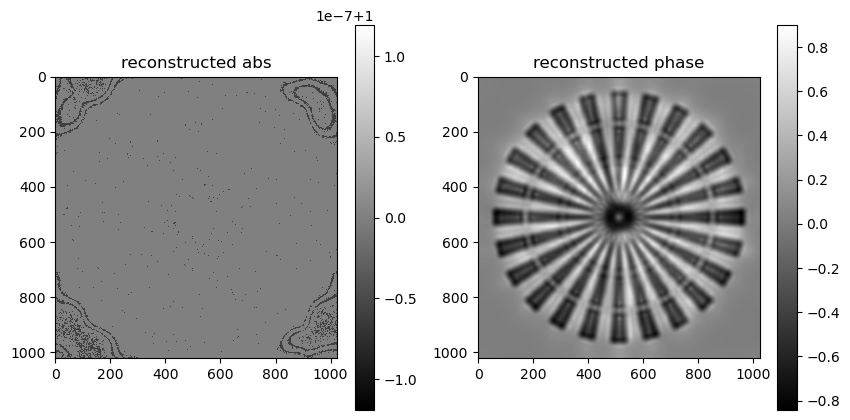

In [36]:
# distances should not be normalized
distances_pag = (distances/norm_magnifications**2)[:ndist]
recMultiPaganin = np.exp(1j*multiPaganin(rdata_scaled_aligned,
                         distances_pag, wavelength, voxelsize,  19, 1e-12))
mshow(recMultiPaganin[0])
# dxchange.write_tiff(np.angle(recMultiPaganin), f'data/rec/MultiPaganin.tiff', overwrite=True)

In [ ]:
# Construct operators


In [ ]:
#### Forward holo: $d=\mathcal{G}_{z_j}\left((\mathcal{G}_{z_j'}\mathcal{S}_{s'_{kj}}q)\mathcal{M}_j\mathcal{S}_{s_{kj}}\psi_k\right)$,
#### Adjoint holo: $\psi=\sum_j\mathcal{S}^H_{s_j}\mathcal{M}_j^H\left((\mathcal{G}_{z_j'}\mathcal{S}_{s'_{kj}}q)^*\mathcal{G}^H_{z_j}d\right)$, 
#### Adjoint holo wrt probe: $q=\sum_{j,k}\mathcal{S}_{s_{kj}'}\mathcal{G}_{z_j'}^H\left((\mathcal{M}_j\mathcal{S}_{s_{kj}}\psi_k)^*\mathcal{G}^H_{z_j}d\right)$



In [37]:

@gpu_batch
def _fwd_holo(psi, shifts_ref, shifts, prb):
    prb = cp.array(prb)
    shifts_ref  = cp.array(shifts_ref)
    shifts  = cp.array(shifts)
    
    data = cp.zeros([psi.shape[0], ndist, n, n], dtype='complex64')
    for i in range(ndist):
        # ill shift for each acquisition
        prbr = cp.tile(prb, [psi.shape[0], 1, 1])

        prbr = S(prbr, shifts_ref[:, i])
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[i])
        # object shift for each acquisition
        psir = S(psi, shifts[:, i]/norm_magnifications[i])

        # scale object
        if ne != n:
            psir = M(psir, norm_magnifications[i]*ne/(n+2*pad), n+2*pad)

        # multiply the ill and object
        psir *= prbr

        # propagate both
        psir = G(psir, wavelength, voxelsize, distances[i])
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data


def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_ref, shifts, prb)


@gpu_batch
def _adj_holo(data, shifts_ref, shifts, prb):
    prb = cp.array(prb)
    shifts_ref  = cp.array(shifts_ref)
    shifts  = cp.array(shifts)
    
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')
    for j in range(ndist):
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))

        # propagate data back
        psir = GT(psir, wavelength, voxelsize, distances[j])

        # ill shift for each acquisition
        prbr = cp.tile(prb, [data.shape[0], 1, 1])
        prbr = S(prbr, shifts_ref[:, j])

        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[j])

        # multiply the conj ill and object
        psir *= cp.conj(prbr)

        # scale object
        if ne != n:
            psir = MT(psir, norm_magnifications[j]*ne/(n+2*pad), ne)
        # object shift for each acquisition
        psi += ST(psir, shifts[:, j]/norm_magnifications[j])
    return psi


def adj_holo(data, prb):
    return _adj_holo(data, shifts_ref, shifts, prb)


@gpu_batch
def _adj_holo_prb(data, shifts_ref, shifts, psi):
    prb = cp.zeros([data.shape[0], n+2*pad, n+2*pad], dtype='complex64')
    for j in range(ndist):
        prbr = np.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        psir = psi.copy()

        # propagate data back
        prbr = GT(prbr, wavelength, voxelsize, distances[j])

        # object shift for each acquisition
        psir = S(psir, shifts[:, j]/norm_magnifications[j])

        # scale object
        psir = M(psir, norm_magnifications[j]*ne/(n+2*pad), n+2*pad)

        # multiply the conj object and ill
        prbr *= cp.conj(psir)

        # propagate illumination
        prbr = GT(prbr, wavelength, voxelsize, distances2[j])

        # ill shift for each acquisition
        prbr = ST(prbr, shifts_ref[:, j])
        prb += prbr
    return prb


def adj_holo_prb(data, psi):
    ''' Adjoint Holography operator '''
    return np.sum(_adj_holo_prb(data, shifts_ref, shifts, psi), axis=0)[np.newaxis]


# adjoint test
data = data0.copy()
ref = ref0.copy()
arr1 = np.pad(np.array(data[:, 0]+1j*data[:, 0]).astype('complex64'),
              ((0, 0), (ne//2-n//2, ne//2-n//2), (ne//2-n//2, ne//2-n//2)), 'symmetric')
prb1 = np.array(ref[0, :1]+1j*ref[0, :1]).astype('complex64')
prb1 = np.pad(prb1, ((0, 0), (pad, pad), (pad, pad)))

arr2 = fwd_holo(arr1, prb1)
arr3 = adj_holo(arr2, prb1)
arr4 = adj_holo_prb(arr2, arr1)

print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')
print(f'{np.sum(prb1*np.conj(arr4))}==\n{np.sum(arr2*np.conj(arr2))}')

(38691564+12.822029113769531j)==
(38691572-6.904126348672435e-05j)
(38691488+6.1875j)==
(38691572-6.904126348672435e-05j)


In [ ]:
#### Forward holo without sample: $d=\mathcal{G}_{z_j}\mathcal{S}_{s'_{j}}q$, 
#### Adjoint holo without sample: $q=\sum_j\mathcal{S}^H_{s'_{j}}\mathcal{G}^H_{z_j}d$

In [38]:
@gpu_batch
def _fwd_holo0(prb, shifts_ref0):
    data = cp.zeros([1, ndist, n, n], dtype='complex64')
    shifts_ref0  = cp.array(shifts_ref0)
    for j in range(ndist):
        # ill shift for each acquisition
        prbr = S(prb, shifts_ref0[:, j])
        # propagate illumination
        data[:, j] = G(prbr, wavelength, voxelsize, distances[0])[:, pad:n+pad, pad:n+pad]
    return data


def fwd_holo0(prb):
    return _fwd_holo0(prb, shifts_ref0)


@gpu_batch
def _adj_holo0(data, shifts_ref0):
    prb = cp.zeros([1, n+2*pad, n+2*pad], dtype='complex64')
    shifts_ref0  = cp.array(shifts_ref0)
    for j in range(ndist):
        # ill shift for each acquisition
        prbr = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        # propagate illumination
        prbr = GT(prbr, wavelength, voxelsize, distances[0])
        # ill shift for each acquisition
        prb += ST(prbr, shifts_ref0[:, j])
    return prb


def adj_holo0(data):
    return _adj_holo0(data, shifts_ref0)


# adjoint test
data = data0[0, :].copy()
ref = ref0.copy()
prb1 = np.array(ref[0, :1]+1j*ref[0, :1]).astype('complex64')
prb1 = np.pad(prb1, ((0, 0), (pad, pad), (pad, pad)))
arr2 = fwd_holo0(prb1)
arr3 = adj_holo0(arr2)

print(f'{np.sum(prb1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

(11117684-1.5390625j)==
(11117705-5.558638440561481e-05j)


In [ ]:
#### Approximate the probe by solving the L2-norm minimization problem for reference images

0) gammaprb=0.5, err=2.11298e+05


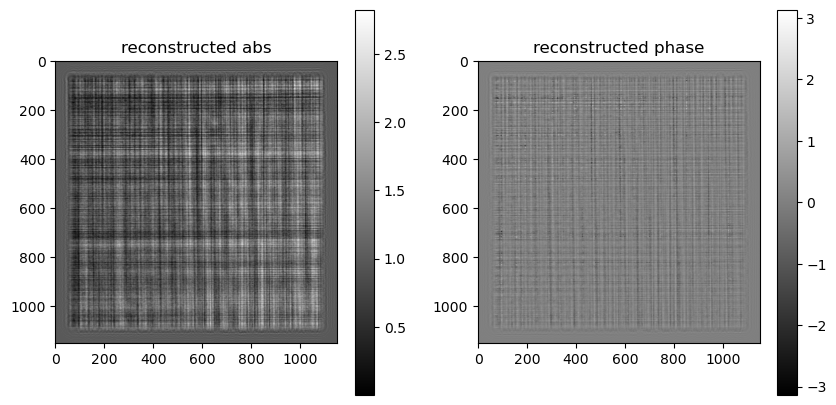

1) gammaprb=0.5, err=2.24406e+04
2) gammaprb=0.5, err=9.08483e+03
3) gammaprb=0.25, err=3.70211e+03
4) gammaprb=0.25, err=2.17992e+03
5) gammaprb=0.5, err=2.17583e+03
6) gammaprb=0.5, err=1.65217e+03
7) gammaprb=0.5, err=1.53926e+03
8) gammaprb=0.5, err=1.32050e+03
9) gammaprb=0.5, err=1.27246e+03
10) gammaprb=0.5, err=1.17870e+03
11) gammaprb=0.25, err=9.26656e+02
12) gammaprb=0.25, err=9.02601e+02
13) gammaprb=0.25, err=7.54923e+02
14) gammaprb=0.125, err=6.62421e+02
15) gammaprb=0.125, err=6.02119e+02
16) gammaprb=0.125, err=5.57155e+02


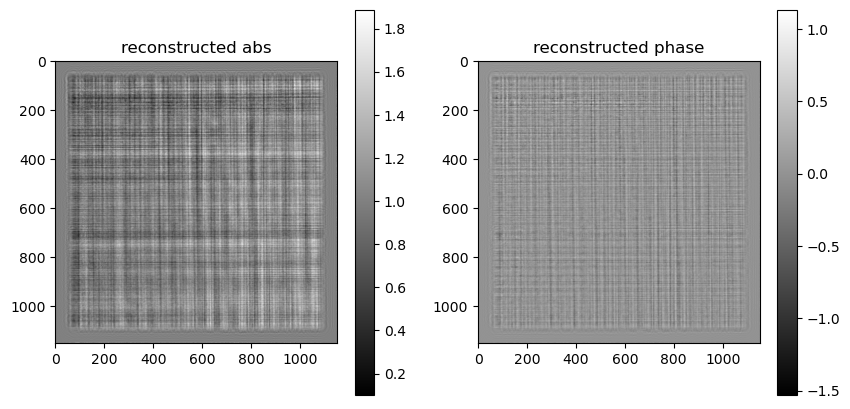

In [39]:
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while (minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if (gamma <= 1e-12):  # direction not found
        # print('no direction')
        gamma = 0
    return gamma


def cg_holo(ref, init_prb,  pars):
    """Conjugate gradients method for holography"""
    # minimization functional
    def minf(fprb):
        f = np.linalg.norm(np.abs(fprb)-ref)**2
        return f

    ref = np.sqrt(ref)
    prb = init_prb.copy()

    for i in range(pars['niter']):
        fprb0 = fwd_holo0(prb)
        gradprb = adj_holo0(fprb0-ref*np.exp(1j*np.angle(fprb0)))

        if i == 0:
            dprb = -gradprb
        else:
            dprb = dai_yuan(dprb,gradprb,gradprb0)
        gradprb0 = gradprb

        # line search
        fdprb0 = fwd_holo0(dprb)
        gammaprb = line_search(minf, pars['gammaprb'], fprb0, fdprb0)
        prb = prb + gammaprb*dprb

        if i % pars['err_step'] == 0:
            fprb0 = fwd_holo0(prb)
            err = minf(fprb0)
            print(f'{i}) {gammaprb=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow(prb[0])

    return prb


rec_prb0 = np.ones([1, n+2*pad, n+2*pad], dtype='complex64')
ref = ref00.copy()
pars = {'niter': 17, 'err_step': 1, 'vis_step': 16, 'gammaprb': 0.5}
rec_prb0 = cg_holo(ref, rec_prb0, pars)

In [ ]:
#### Main reconstruction. $\ \sum_k\sum_j||\mathcal{G}_{z_j}((\mathcal{G}_{z'_j}S_{s'_{kj}}q)(M_j S_{s_{kj}}\psi_k))|-\sqrt{d_{kj}}\|^2_2 + \||\mathcal{G}_{z_0}S_{s^r_j}q|-\sqrt{d^r}\|_2^2\to \text{min}_{\psi_k,q}$ 

0) gammapsi=0.5 gammaprb=0.5, err=3.19738e+04


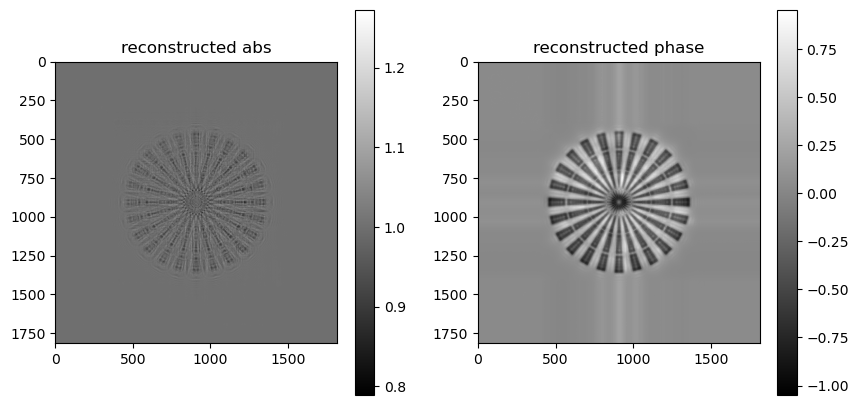

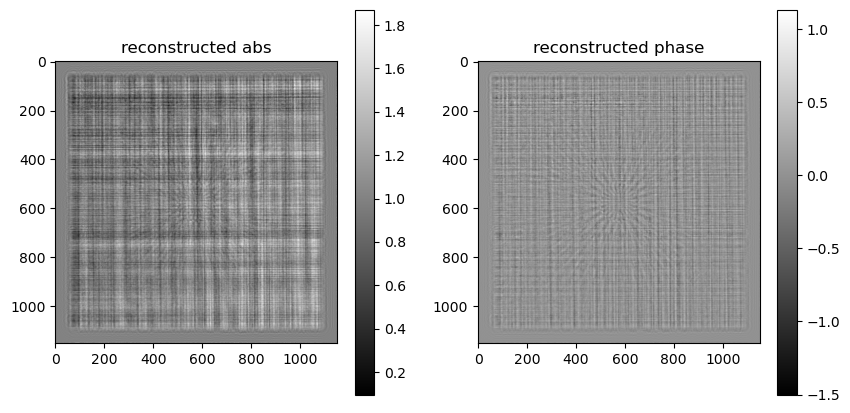

8) gammapsi=0.5 gammaprb=0.5, err=2.86512e+03
16) gammapsi=0.5 gammaprb=0.5, err=1.49764e+03
24) gammapsi=0.5 gammaprb=0.5, err=1.05401e+03
32) gammapsi=0.5 gammaprb=0.5, err=8.32919e+02


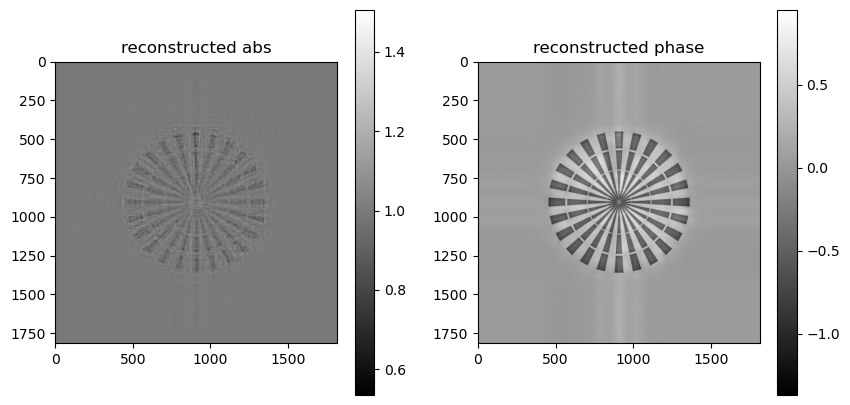

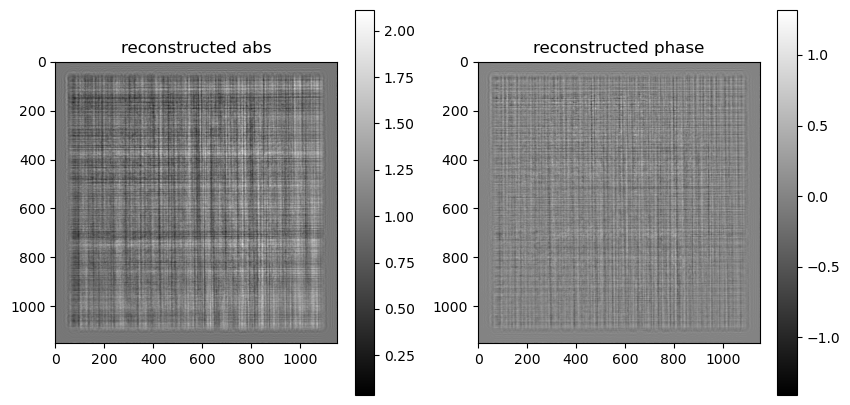

40) gammapsi=0.5 gammaprb=0.5, err=7.01328e+02
48) gammapsi=0.5 gammaprb=0.5, err=6.15396e+02
56) gammapsi=0.5 gammaprb=0.5, err=5.56971e+02
64) gammapsi=0.25 gammaprb=0.5, err=5.14104e+02


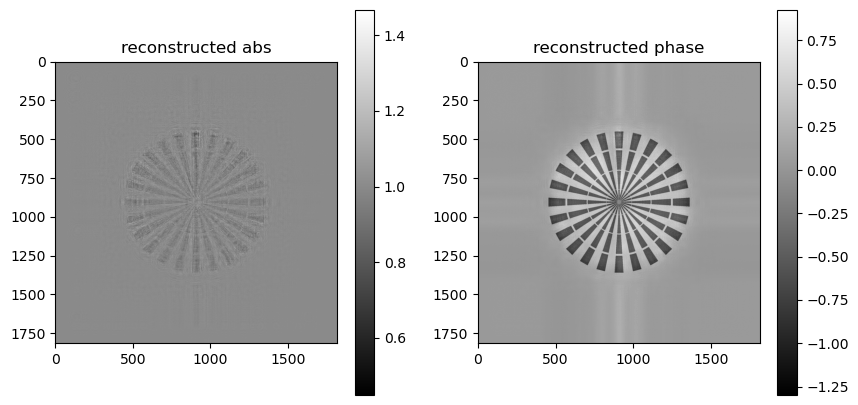

KeyboardInterrupt: 

In [40]:

def line_search(minf, gamma, fu, fu0, fd, fd0):
    """ Line search for the step sizes gamma"""
    while (minf(fu, fu0)-minf(fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma >= 1/64):
        gamma *= 0.5
    if (gamma < 1/64):  # direction not found
        # print('no direction')
        gamma = 0
    return gamma


@gpu_batch
def _gradient(psi, data, shifts_ref, shifts, prb):
    prb = cp.array(prb)
    shifts_ref  = cp.array(shifts_ref)
    shifts  = cp.array(shifts)
    
    res = cp.zeros([psi.shape[0], ne, ne], dtype='complex64')
    fpsires = cp.zeros([psi.shape[0], ndist, n, n], dtype='complex64')
    for j in range(ndist):
        # ill shift for each acquisition
        prbr = cp.tile(prb, [psi.shape[0], 1, 1])
        prbr = S(prbr, shifts_ref[:, j])
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[j])
        # object shift for each acquisition
        psir = S(psi, shifts[:, j]/norm_magnifications[j])

        # scale object
        if ne != n:
            psir = M(psir, norm_magnifications[j]*ne/(n+2*pad), n+2*pad)

        # multiply the ill and object
        psir *= prbr

        # propagate both
        psir = G(psir, wavelength, voxelsize, distances[j])
        fpsi = psir[:, pad:n+pad, pad:n+pad]
        fpsires[:, j] = fpsi

        ###########################
        psir = fpsi-data[:, j]*np.exp(1j*(np.angle(fpsi)))

        psir = cp.pad(psir, ((0, 0), (pad, pad), (pad, pad)))

        # propagate data back
        psir = GT(psir, wavelength, voxelsize, distances[j])

        # ill shift for each acquisition
        prbr = cp.tile(prb, [psi.shape[0], 1, 1])
        prbr = S(prbr, shifts_ref[:, j])

        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[j])

        # multiply the conj ill and object
        psir *= cp.conj(prbr)

        # scale object
        if ne != n:
            psir = MT(psir, norm_magnifications[j]*ne/(n+2*pad), ne)
        # object shift for each acquisition
        res += ST(psir, shifts[:, j]/norm_magnifications[j])

    # probe normalization
    res /= cp.amax(cp.abs(prb))**2
    return [res, fpsires]


def gradient(psi, data, prb):
    ''' Gradient wrt psi'''
    return _gradient(psi, data, shifts_ref, shifts, prb)


@gpu_batch
def _gradientprb(psi, data, shifts_ref, shifts, prb):
    prb = cp.array(prb)
    shifts_ref  = cp.array(shifts_ref)
    shifts  = cp.array(shifts)
    res = cp.zeros([psi.shape[0], n+2*pad, n+2*pad], dtype='complex64')
    fpsires = cp.zeros([psi.shape[0], ndist, n, n], dtype='complex64')
    for j in range(ndist):
        # ill shift for each acquisition
        prbr = cp.tile(prb, [psi.shape[0], 1, 1])
        prbr = S(prbr, shifts_ref[:, j])
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[j])
        # object shift for each acquisition
        psir = S(psi, shifts[:, j]/norm_magnifications[j])

        # scale object
        if ne != n:
            psir = M(psir, norm_magnifications[j]*ne/(n+2*pad), n+2*pad)

        # multiply the ill and object
        psir *= prbr

        # propagate both
        psir = G(psir, wavelength, voxelsize, distances[j])
        fpsi = psir[:, pad:n+pad, pad:n+pad]
        fpsires[:, j] = fpsi

    ###########################
        fpsi = fpsi-data[:, j]*np.exp(1j*(np.angle(fpsi)))

        prbr = np.pad(fpsi, ((0, 0), (pad, pad), (pad, pad)))
        psir = psi.copy()

        # propagate data back
        prbr = GT(prbr, wavelength, voxelsize, distances[j])

        # object shift for each acquisition
        psir = S(psir, shifts[:, j]/norm_magnifications[j])

        # scale object
        psir = M(psir, norm_magnifications[j]*ne/(n+2*pad), n+2*pad)

        # multiply the conj object and ill
        prbr *= cp.conj(psir)

        # propagate illumination
        prbr = GT(prbr, wavelength, voxelsize, distances2[j])

        # ill shift for each acquisition
        prbr = ST(prbr, shifts_ref[:, j])
        res += prbr

    return [res, fpsires]


def gradientprb(psi, data, prb):
    ''' Gradient wrt prb'''
    [gradprb, fprb] = _gradientprb(psi, data, shifts_ref, shifts, prb)
    gradprb = np.sum(gradprb, axis=0)[np.newaxis]
    return [gradprb, fprb]


def cg_holo(data, ref, init, init_prb,  pars):
    """Conjugate gradients method for holography"""
    # minimization functional

    def minf(fpsi, fprb):
        f = np.linalg.norm(np.abs(fpsi)-data)**2
        if isinstance(fprb, np.ndarray) or isinstance(fprb, cp.ndarray):
            f += np.linalg.norm(np.abs(fprb)-ref)**2
        return f

    data = np.sqrt(data)
    ref = np.sqrt(ref)

    psi = init.copy()
    prb = init_prb.copy()
    conv = np.zeros(1+pars['niter']//pars['err_step'])

    for i in range(pars['niter']):
        if pars['upd_psi']:
            [grad, fpsi] = gradient(psi, data, prb)
            # Dai-Yuan direction
            if i == 0:
                d = -grad
            else:
                d = dai_yuan(d,grad,grad0)

            grad0 = grad
            fd = fwd_holo(d, prb)
            gammapsi = line_search(minf, pars['gammapsi'], fpsi, 0, fd, 0)
            psi = linear(psi,d,1,gammapsi)

        if pars['upd_prb']:
            [gradprb, fprb] = gradientprb(psi, data, prb)
            fprb0 = fwd_holo0(prb)
            gradprb += adj_holo0(fprb0-ref*np.exp(1j*np.angle(fprb0)))
            gradprb *= 1/(ntheta+1)

            # Dai-Yuan direction
            if i == 0:
                dprb = -gradprb
            else:
                dprb = dai_yuan(dprb,gradprb,gradprb0)
            gradprb0 = gradprb

            # line search
            fdprb = fwd_holo(psi, dprb)
            fdprb0 = fwd_holo0(dprb)
            gammaprb = line_search(
                minf, pars['gammaprb'], fprb, fprb0, fdprb, fdprb0)
            prb = prb + gammaprb*dprb

        if i % pars['err_step'] == 0:
            fprb = fwd_holo(psi, prb)
            fprb0 = fwd_holo0(prb)
            err = minf(fprb, fprb0)
            conv[i//pars['err_step']] = err
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow(psi[0])
            mshow(prb[0])
            
    return psi, prb, conv

# if by chunk on gpu
# rec = np.pad(recMultiPaganin, ((0, 0), (ne//2-n//2, ne//2-n//2),
#              (ne//2-n//2, ne//2-n//2)), 'edge')
# rec_prb = rec_prb0.copy()
# ref = ref00.copy()
# data = data00.copy()


#if fully on gpu:
rec = cp.pad(cp.array(recMultiPaganin), ((0, 0), (ne//2-n//2, ne//2-n//2),
             (ne//2-n//2, ne//2-n//2)), 'edge')
rec_prb = cp.array(rec_prb0)
ref = cp.array(ref00)
data = cp.array(data00)

pars = {'niter': 129, 'upd_psi': True, 'upd_prb': True,
        'err_step': 8, 'vis_step': 32, 'gammapsi': 0.5, 'gammaprb': 0.5}
rec, rec_prb, conv = cg_holo(data, ref, rec, rec_prb, pars)


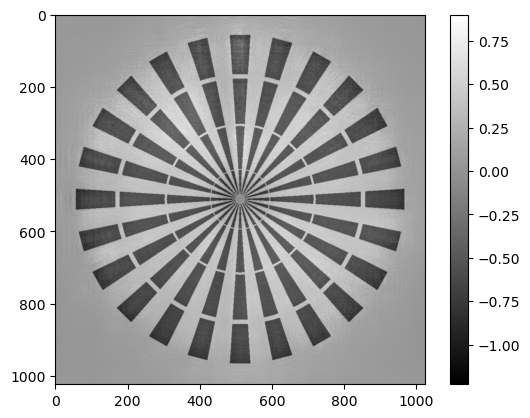

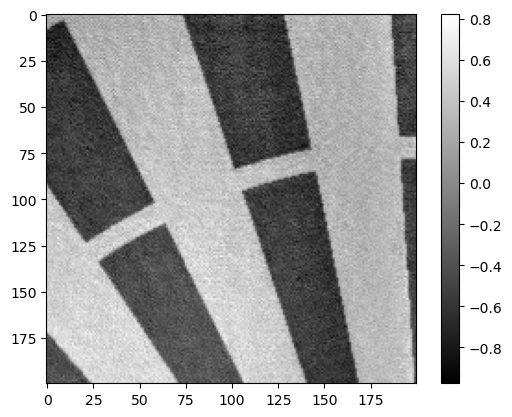

In [ ]:
plt.imshow(cp.angle(rec[0,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]).get(), cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(cp.angle(rec[0,ne//2-n//2+100:ne//2-n//2+300,ne//2-n//2+300:ne//2-n//2+500]).get(), cmap='gray')
plt.colorbar()
plt.show()